In [1]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
using Plots
using BenchmarkTools
include("/mnt/c/Users/gdzhao/projects/compuational_physics/global/iterators.jl");
include("/mnt/c/Users/gdzhao/projects/compuational_physics/global/pdfSample.jl");

[0.6066680908203125, 0.7874772705078126, 0.4253120940553998, 0.84903464090964, 0.3021769654816825, 0.6053232956834134, 0.7901650507581293, 0.41953704730202146, 0.8374871016033488, 0.3254981406962429]


## Multi-threaded Computation 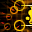

In [3]:
Threads.nthreads()

4

In [4]:
Threads.@threads for i in 1:10
    id = Threads.threadid()
    println("Hello ,I am thread number $id ")
    # code that does something
end

Hello ,I am thread number 1 
Hello ,I am thread number 3 
Hello ,I am thread number 4 
Hello ,I am thread number 2 
Hello ,I am thread number 3 
Hello ,I am thread number 4 
Hello ,I am thread number 4 
Hello ,I am thread number 2 
Hello ,I am thread number 4 
Hello ,I am thread number 3 


In [5]:
@. g(x) = 1.0+0.5*cos(x/2.0)

g (generic function with 1 method)

In [6]:
# nsample = 10000
# interval = (0.0,4.0*pi)
# x,cdf = pdf2cdf(nsample,g,interval)

# cachePath = "/mnt/c/Users/gdzhao/projects/compuational_physics/ex02/cache/"
# fileName = "cdf_LandauDamping.txt"

# cdf2cache(x,cdf,joinpath(cachePath,fileName))

In [7]:
cachePath = "/mnt/c/Users/gdzhao/projects/compuational_physics/ex02/cache/"
fileName = "cdf_LandauDamping.txt"
nsample = 10000

x,cdf = cache2cdf(nsample,joinpath(cachePath,fileName))

([0.0, 0.0012567627377096883, 0.0025135254754193766, 0.003770288213129065, 0.005027050950838753, 0.006283813688548441, 0.00754057642625813, 0.008797339163967818, 0.010054101901677506, 0.011310864639387195  …  12.555059749719785, 12.556316512457496, 12.557573275195205, 12.558830037932914, 12.560086800670623, 12.561343563408334, 12.562600326146043, 12.563857088883752, 12.565113851621463, 12.566370614359172], [0.0, 0.00015001499656386733, 0.0003000299733826055, 0.0004500449107110932, 0.0006000597888042246, 0.0007500745879169174, 0.0009000892883041203, 0.0010501038702208211, 0.0012001183139220548, 0.00135013259966291  …  0.998649867400337, 0.9987998816860781, 0.9989498961297792, 0.9990999107116958, 0.9992499254120829, 0.9993999402111958, 0.9995499550892889, 0.9996999700266173, 0.9998499850034362, 1.0])

In [8]:
function rng_single(ntest,x,cdf)
    cdfInverse = cdfInverseInterp(x,cdf)
    test_distribution = zeros(ntest)
    for i in 1:ntest
        test_distribution[i] = cdfInverse(rand())
    end
    return test_distribution
end

function rng_multi(ntest,x,cdf)
    cdfInverse = cdfInverseInterp(x,cdf)
    test_distribution = zeros(ntest)
    Threads.@threads for i in 1:ntest
        test_distribution[i] = cdfInverse(rand())
    end
    return test_distribution
end

rng_multi (generic function with 1 method)

In [9]:
ntest = 100000

@btime rng_single($ntest,$x,$cdf)

@btime rng_multi($ntest,$x,$cdf)

  7.636 ms (28 allocations: 1.03 MiB)
  2.059 ms (49 allocations: 1.03 MiB)


100000-element Vector{Float64}:
  2.803488114270264
  7.948249042666019
  6.315050400716389
  0.3502568035475544
  8.712315227047096
  0.15903833310474083
  1.4709268588035231
  1.7984061810482697
  4.203819056158068
  2.217276104353849
  9.59290458955542
 10.497187685253518
  4.85032657282511
  ⋮
 10.073276204291107
  8.198710928106198
  1.8862416504324537
  9.728084343463845
  2.3826126365894518
  0.48367590860104387
 10.68505120032652
  2.5134810197677107
 12.19057928907638
  9.920462688215432
 10.857087126564958
  4.670836816817056

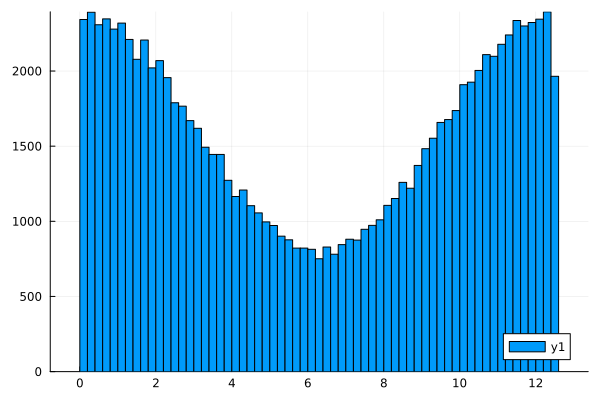

In [10]:
test_distribution = rng_multi(ntest,x,cdf)

histogram(test_distribution,nbins=100)

In [11]:
t1 = @belapsed rng_single(ntest,x,cdf)
t4 = @belapsed rng_multi(ntest,x,cdf)

println("efficiency = $(t1/t4)")

efficiency = 3.714143389113489


In [ ]:
ntest_list = [10^i for i in 1:6]
t_single = zeros(length(ntest_list))

for i in 1:length(ntest_list)
    ntest = ntest_list[i]
    t_single[i] = @belapsed rng_single(ntest,x,cdf)
end

t_multi = zeros(length(ntest_list))

for i in 1:length(ntest_list)
    ntest = ntest_list[i]
    t_multi[i] = @belapsed rng_multi(ntest,x,cdf)
end

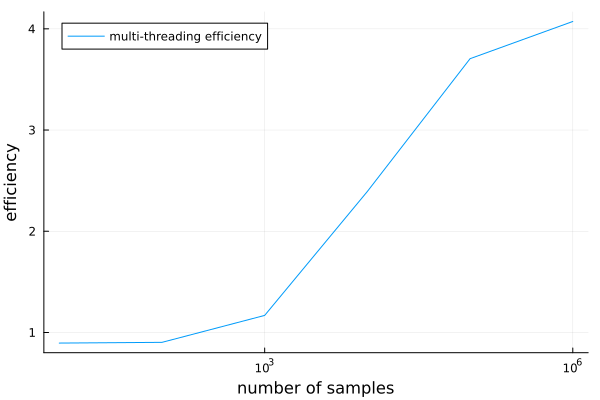

In [43]:
plot(ntest_list,t_single./t_multi,xscale=:log10,legend=:topleft,label="multi-threading efficiency",xlabel="number of samples",ylabel="efficiency")

### Test result
The multi-threading efficiency increases as ntest grows, and eventually approaches 4.

***But wait what***

the sample at 10^6 has effiency exceeding 4, that must be something wrong.

## Distributed Memory Processes 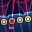

In [44]:
using Pkg
Pkg.add("Distributed")
Pkg.add("DistributedArrays")

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [8ba89e20] + Distributed
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
   Installed DistributedArrays ─ v0.6.7
    Updating `~/.julia/environments/v1.10/Project.toml`
  [aaf54ef3] + DistributedArrays v0.6.7
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [aaf54ef3] + DistributedArrays v0.6.7
Precompiling project...
  ✓ DistributedArrays
  1 dependency successfully precompiled in 1 seconds. 254 already precompiled.


In [13]:
using Distributed
using DistributedArrays

In [12]:
function xintervalGen(x,cdf,nProcess::Int)
    xintervalEdges = zeros(nProcess+1)
    cdfInverse = cdfInverseInterp(x,cdf)
    
    for i in 2:(nProcess+1)
        xintervalEdges[i] = cdfInverse((i-1)/nProcess)
    end

    return xintervalEdges
end

function intervalRescale(x::Float64,iProcess::Int,nProcess::Int)
    # rescale x from random in 0,1 to random in (iProcess-1)/nProcess,iProcess/nProcess
    return x/nProcess + (iProcess-1)/nProcess
end

xintervalGen(x,cdf,4)

5-element Vector{Float64}:
  0.0
  2.2412254877235775
  6.283185307179572
 10.325145126635585
 12.566370614359172

In [ ]:
addprocs(4)


In [16]:
# @everywhere function intervalRescale(x::Float64,iProcess::Int,nProcess::Int)
#     # rescale x from random in 0,1 to random in (iProcess-1)/nProcess,iProcess/nProcess
#     return x/nProcess + (iProcess-1)/nProcess
# end

# @everywhere include("/mnt/c/Users/gdzhao/projects/compuational_physics/global/pdfSample.jl");

@everywhere function randomInInterval(nsampleTot::Int,nProcess::Int)

    # cachePath = "/mnt/c/Users/gdzhao/projects/compuational_physics/ex02/cache/"
    # fileName = "cdf_LandauDamping.txt"

    # randoms = rand(div(nsampleTot,nProcess))
    # randoms = intervalRescale.(randoms,iProcess,nProcess)

    # x,cdf = cache2cdf(10000,joinpath(cachePath,fileName))
    # cdfInverse = cdfInverseInterp(x,cdf)
    randoms = rand(div(nsampleTot,nProcess))

    return randoms
end

In [90]:
# function randomInInterval(nsampleTot::Int,iProcess::Int,nProcess::Int)

#     cachePath = "/mnt/c/Users/gdzhao/projects/compuational_physics/ex02/cache/"
#     fileName = "cdf_LandauDamping.txt"

#     randoms = rand(div(nsampleTot,nProcess))
#     randoms = intervalRescale.(randoms,iProcess,nProcess)

#     x,cdf = cache2cdf(10000,joinpath(cachePath,fileName))
#     cdfInverse = cdfInverseInterp(x,cdf)
    
#     return cdfInverse.(randoms)
# end

# xtest = randomInInterval(1000,1,4)
# histogram(xtest,nbins=10)

In [15]:
workers()

4-element Vector{Int64}:
 2
 3
 4
 5

In [19]:
parts = [@spawnat worker randomInInterval(10000,4) for worker in workers()]

4-element Vector{Future}:
 Future(2, 1, 30, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 139824817246960, 0)), nothing)
 Future(3, 1, 31, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 139824817238320, 0)), nothing)
 Future(4, 1, 32, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 139824817242352, 4)), nothing)
 Future(5, 1, 33, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (2, 139824662826112, 139824662835024)), nothing)

In [24]:
random_sample = []

for i in 1:4
    part = fetch(parts[i])
    # rescale x from random in 0,1 to random in (iProcess-1)/nProcess,iProcess/nProcess
    random_list = part./4.0 .+ (i-1)/4.0
    append!(random_sample,random_list)
end

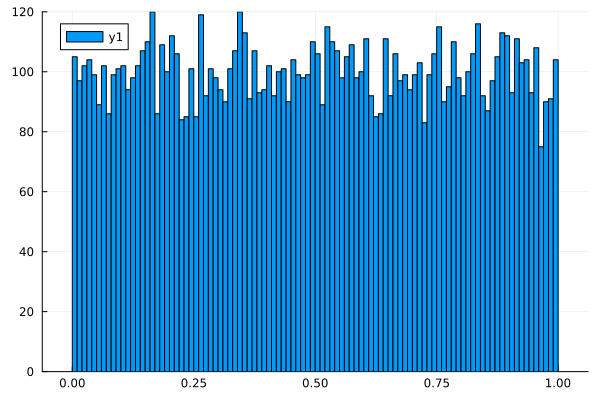

In [25]:
histogram(random_sample,nbins=100)

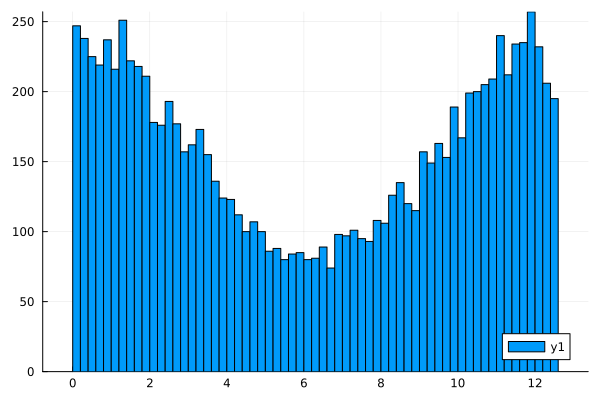

In [27]:
cdfInverse = cdfInverseInterp(x,cdf)

test_distribution = cdfInverse.(random_sample)

histogram(test_distribution,nbins=100)

In [95]:
## clear all workers
for worker in workers()
    rmprocs(worker)
end

## 3D distribution of scattered points

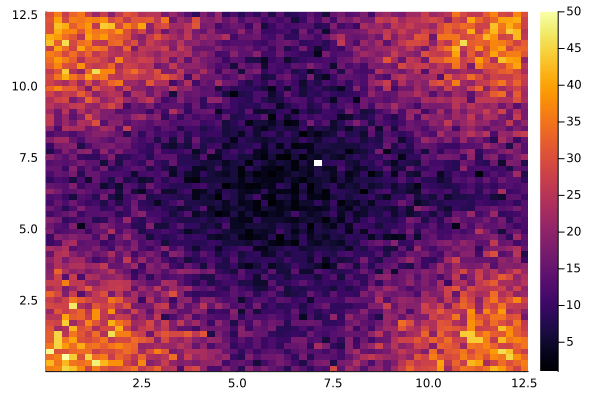

In [28]:
ntest = 2^16

xs = rng_multi(ntest,x,cdf)
ys = rng_multi(ntest,x,cdf)
zs = rng_multi(ntest,x,cdf)

histogram2d(xs,ys,nbins=100)

In [31]:
# save x,y,z to csv file
filename = "random_sample.csv"
resultpath = "/mnt/c/Users/gdzhao/projects/compuational_physics/ex02/result/"

open(joinpath(resultpath,filename),"w") do io
    println(io,"x,y,z")
    for i in 1:ntest
        println(io,"$(xs[i]),$(ys[i]),$(zs[i])")
    end
end
